In [7]:

import cooler
import cooltools
from cooltools.api.saddle import _make_cis_obsexp_fetcher
from cooltools.lib import numutils
from coolpuppy import coolpup
from coolpuppy.lib.puputils import divide_pups
from coolpuppy import plotpup

import bioframe
import numpy as np
import pandas as pd
import bbi

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

import multiprocessing

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [8]:
NPROC = 4
samples = ["t0", "t12"]
clrs_ = [
    cooler.Cooler(
        f"/home/carlos/oldies/manuscripts/notebooks/matrices/{sample}_q30.mcool::resolutions/10000"
    )
    for sample in samples
]

In [ ]:
res_path = "/home/carlos/oldies/manuscripts/notebooks/gnn/results.tsv"
res = pd.read_csv(res_path, sep="\t")
res = res.rename(columns={"chr": "chrom"})
res = res.dropna(subset=['t0_q30-t12_q30', 't12_q30-t0_q30'], inplace=False)
res

In [10]:
comps = list(itertools.product([0,1], [0,1]))


In [11]:
flank = 500_000
import itertools

comps = list(itertools.product([0,1], [0,1]))

filter_for_highest_quartile = False
merge_regions = True

regions_df_ = []
for idx, (i1, i2) in enumerate(comps):
    df = res.loc[(res['t0_q30-t12_q30-clf'] == i1) & (res['t12_q30-t0_q30-clf'] == i2)].copy()

    if filter_for_highest_quartile:
        if i1 == 0:
            df = df.loc[df['t0_q30-t12_q30'] > df['t0_q30-t12_q30'].quantile(0.75)]
        if i2 == 0:
            df = df.loc[df['t12_q30-t0_q30'] > df['t12_q30-t0_q30'].quantile(0.75)]

    if merge_regions:
        merged_regions = bioframe.ops.merge(df, 0)
        merged_regions['start'] = merged_regions.apply(lambda x: x['start'] + (x['end'] - x['start']) // 2 - 5000, axis=1)
        merged_regions['end'] = merged_regions['start'] + 10000
        merged_regions['comp'] = f"{i1}-{i2}"
        regions_df_.append(merged_regions)

regions_df = pd.concat(regions_df_)

In [26]:
import data_handlers

In [27]:
import bbi
dnase_df = regions_df.copy()
dnase_df['val'] = bbi.stackup("/home/carlos/oldies/manuscripts/notebooks/bws/dnase.rpkm.bw", regions_df['chrom'], regions_df['start'], regions_df['end'], 1) / data_handlers.MEANS_BW['dnase']
dnase_df['data_name'] = "dnase"

faire_df = regions_df.copy()
faire_df['val'] = bbi.stackup("/home/carlos/Downloads/ENCFF000TKE_hg38.bigWig", regions_df['chrom'], regions_df['start'], regions_df['end'], 1).flatten() / data_handlers.MEANS_BW['faire']
faire_df['data_name'] = "faire"

data_df = pd.concat([dnase_df, faire_df])

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0-0 vs. 0-1: Mann-Whitney-Wilcoxon test two-sided, P_val:5.132e-164 U_stat=2.029e+08
0-1 vs. 1-0: Mann-Whitney-Wilcoxon test two-sided, P_val:2.154e-93 U_stat=1.252e+08
1-0 vs. 1-1: Mann-Whitney-Wilcoxon test two-sided, P_val:8.304e-154 U_stat=2.083e+08
0-0 vs. 1-0: Mann-Whitney-Wilcoxon test two-sided, P_val:6.425e-08 U_stat=1.355e+08
0-1 vs. 1-1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.172e-07 U_stat=2.464e+08
0-0 vs. 1-1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.723e-253 U_stat=2.601e+08
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0-0 vs. 0-1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.259e-49 U_stat=2.082e+08
0-1 vs. 1-0: Mann-Whitney

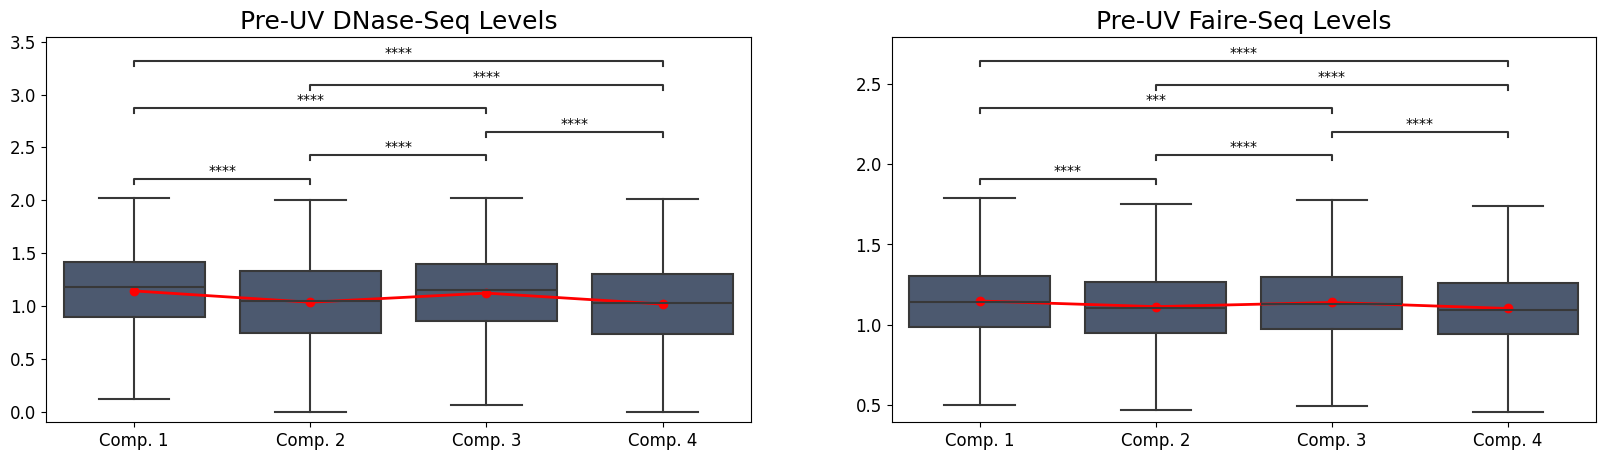

In [30]:
data_name_mapping_anchors = {
    'dnase' : 'Pre-UV DNase-Seq Levels',
    'faire' : 'Pre-UV Faire-Seq Levels'
}
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
s_colors = ['#465775', '#A63446', '#F5B841', '#9DBBAE']
import itertools

comp_dict = {'0-0': 'Comp. 1', '0-1': 'Comp. 2', '1-0': 'Comp. 3', '1-1': 'Comp. 4'}

import numpy as np

for i, data_name in enumerate(data_name_mapping_anchors):
    ax = axs[i]
    df_now = data_df.loc[data_df['data_name'] == data_name].copy()

    # Plot the boxplots
    sns.boxplot(data=df_now, x='comp', y='val', ax=ax, showfliers=False, palette=["#465775"])

    # Calculate the means for each category
    means = df_now.groupby('comp')['val'].mean()

    # Plot the means as red lines connecting them
    comp_order = df_now['comp'].unique()
    x_positions = np.arange(len(comp_order))  # Get x-positions of the boxplots
    ax.plot(x_positions, means, color='red', marker='o', linestyle='-', lw=2, label='Mean')

    # Add statistical annotations
    pairs = list(itertools.combinations(df_now['comp'].unique(), 2))
    from statannotations.Annotator import Annotator
    annotator = Annotator(ax, pairs, data=df_now, x='comp', y='val')
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
    annotator.apply_and_annotate()

    # Customize plot appearance
    ax.set_title(f'{data_name_mapping_anchors[data_name]}', fontsize=18)
    ax.set_ylabel('')
    ax.set_xlabel('')

    # set xtick labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels([comp_dict[comp] for comp in comp_order], fontsize=18)

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)

fig.savefig("/home/carlos/oldies/manuscripts/review/reworked_figs/gnn_dnase_faire.png", dpi=300, bbox_inches='tight')
fig.savefig("/home/carlos/oldies/manuscripts/review/reworked_figs/gnn_dnase_faire.svg", bbox_inches='tight')